In [1]:
# lines starting with '%' are notebook magic functions
# %matplotlib notebook
%matplotlib notebook
%pylab
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

# standard python packages
import os
import re
import numpy as np
import h5py as h5
import pandas as pd
import time
import tqdm
import scipy.integrate as integrate
from scipy.stats import gamma as gammafunc
from scipy.special import gamma
from scipy.stats import norm
import xarray as xr

# main analysis software can be installed by: pip install Xana
from Xana import Xana
from Xana.misc.add_colorbar import add_colorbar

# reading AGIPD data provided by XFEL
from extra_data import RunDirectory, stack_detector_data, by_index, by_id
from extra_geom import AGIPD_1MGeometry
from extra_data.components import AGIPD1M

# for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ML
from sklearn.ensemble import IsolationForest

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

import seaborn as sns
sns.set_context('notebook',)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
geom = AGIPD_1MGeometry.from_crystfel_geom("/gpfs/exfel/data/user/reiserm/projects/proteins/mid-p2458/midtools/midtools/setup_config/geo_assembled_3a.geom")

# Preparation

## Load Metadata from Google Sheet

In [3]:
from scipy.stats import sem
from functools import reduce
from collections import namedtuple
from functools import wraps
from Xana.XpcsAna.pyxpcs3 import pyxpcs
from midtools import Dataset as midDataset
from Xana.Xfit.fitg2global import G2
from Xana.Xfit.fit_basic import fit_basic

from midtools.plotting import Dataset, get_datasets, visit_h5
from midtools.plotting import calc_flux, calc_dose, calc_snr, calc_speckle_size, calc_speckle_contrast
from midtools.plotting import find_percent, find_size, is_processed

In [92]:
meta.rename?

In [4]:
meta = pd.read_csv('./run-metadata.csv', header=0) # csv table downloaded from google drive
meta = meta.drop(index=np.arange(6)).set_index('Run number')
meta.rename(columns={'Sample':'sample', 'Attenuation %':'att (%)'}, inplace=True)
meta.head()

,sample,Start temperature,End temperature,T ramp,Time after quenching,Position,Short comment,Pulse energy / mJ,Number of trains,Pulses per train,...,N pulses,Pulse spacing / us,Beam size / um,att (%),Thickness of silicon / mm,Photon energy / keV,NAFO,Vacuum\n (mbar),Long Comment,g2 comments
Run number,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Datasets

In [5]:
directory = '/gpfs/exfel/u/scratch/MID/202022/p002693/reiserm/datasets/'
datasets = get_datasets(directory)

In [ ]:
visit_h5(datasets.file[-1])

## Overview

<IPython.core.display.Javascript object>


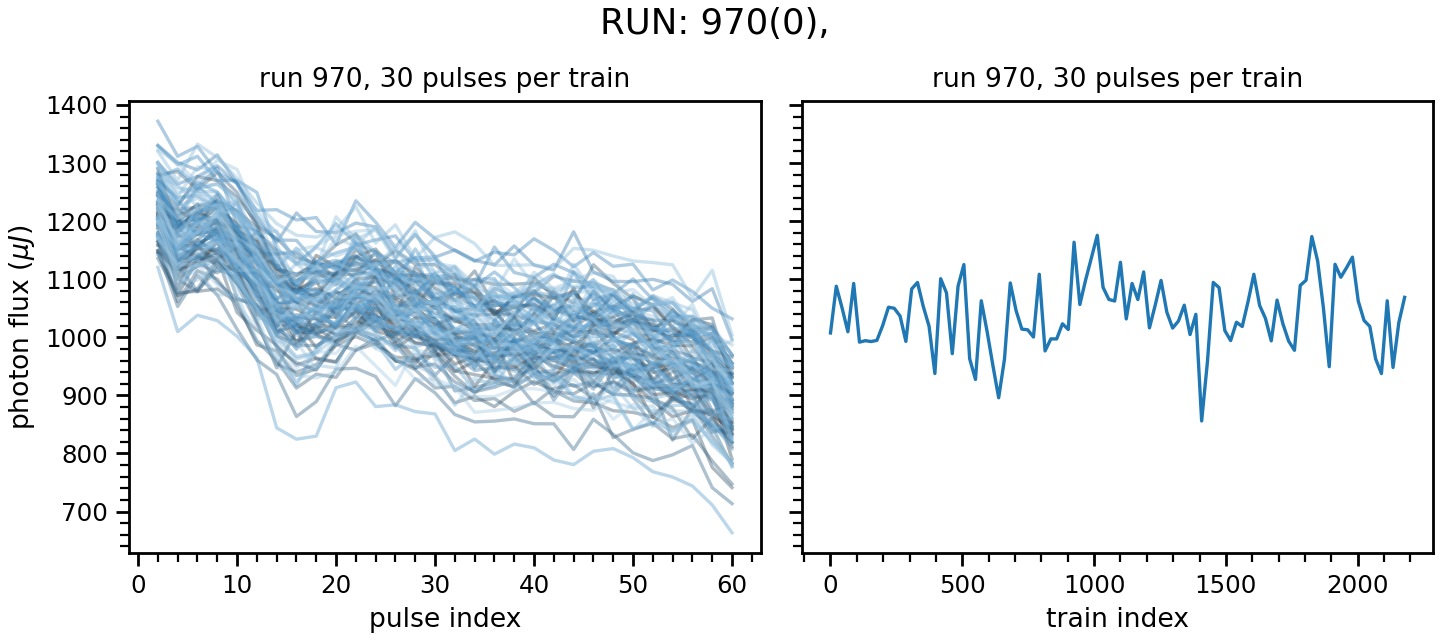

<IPython.core.display.Javascript object>


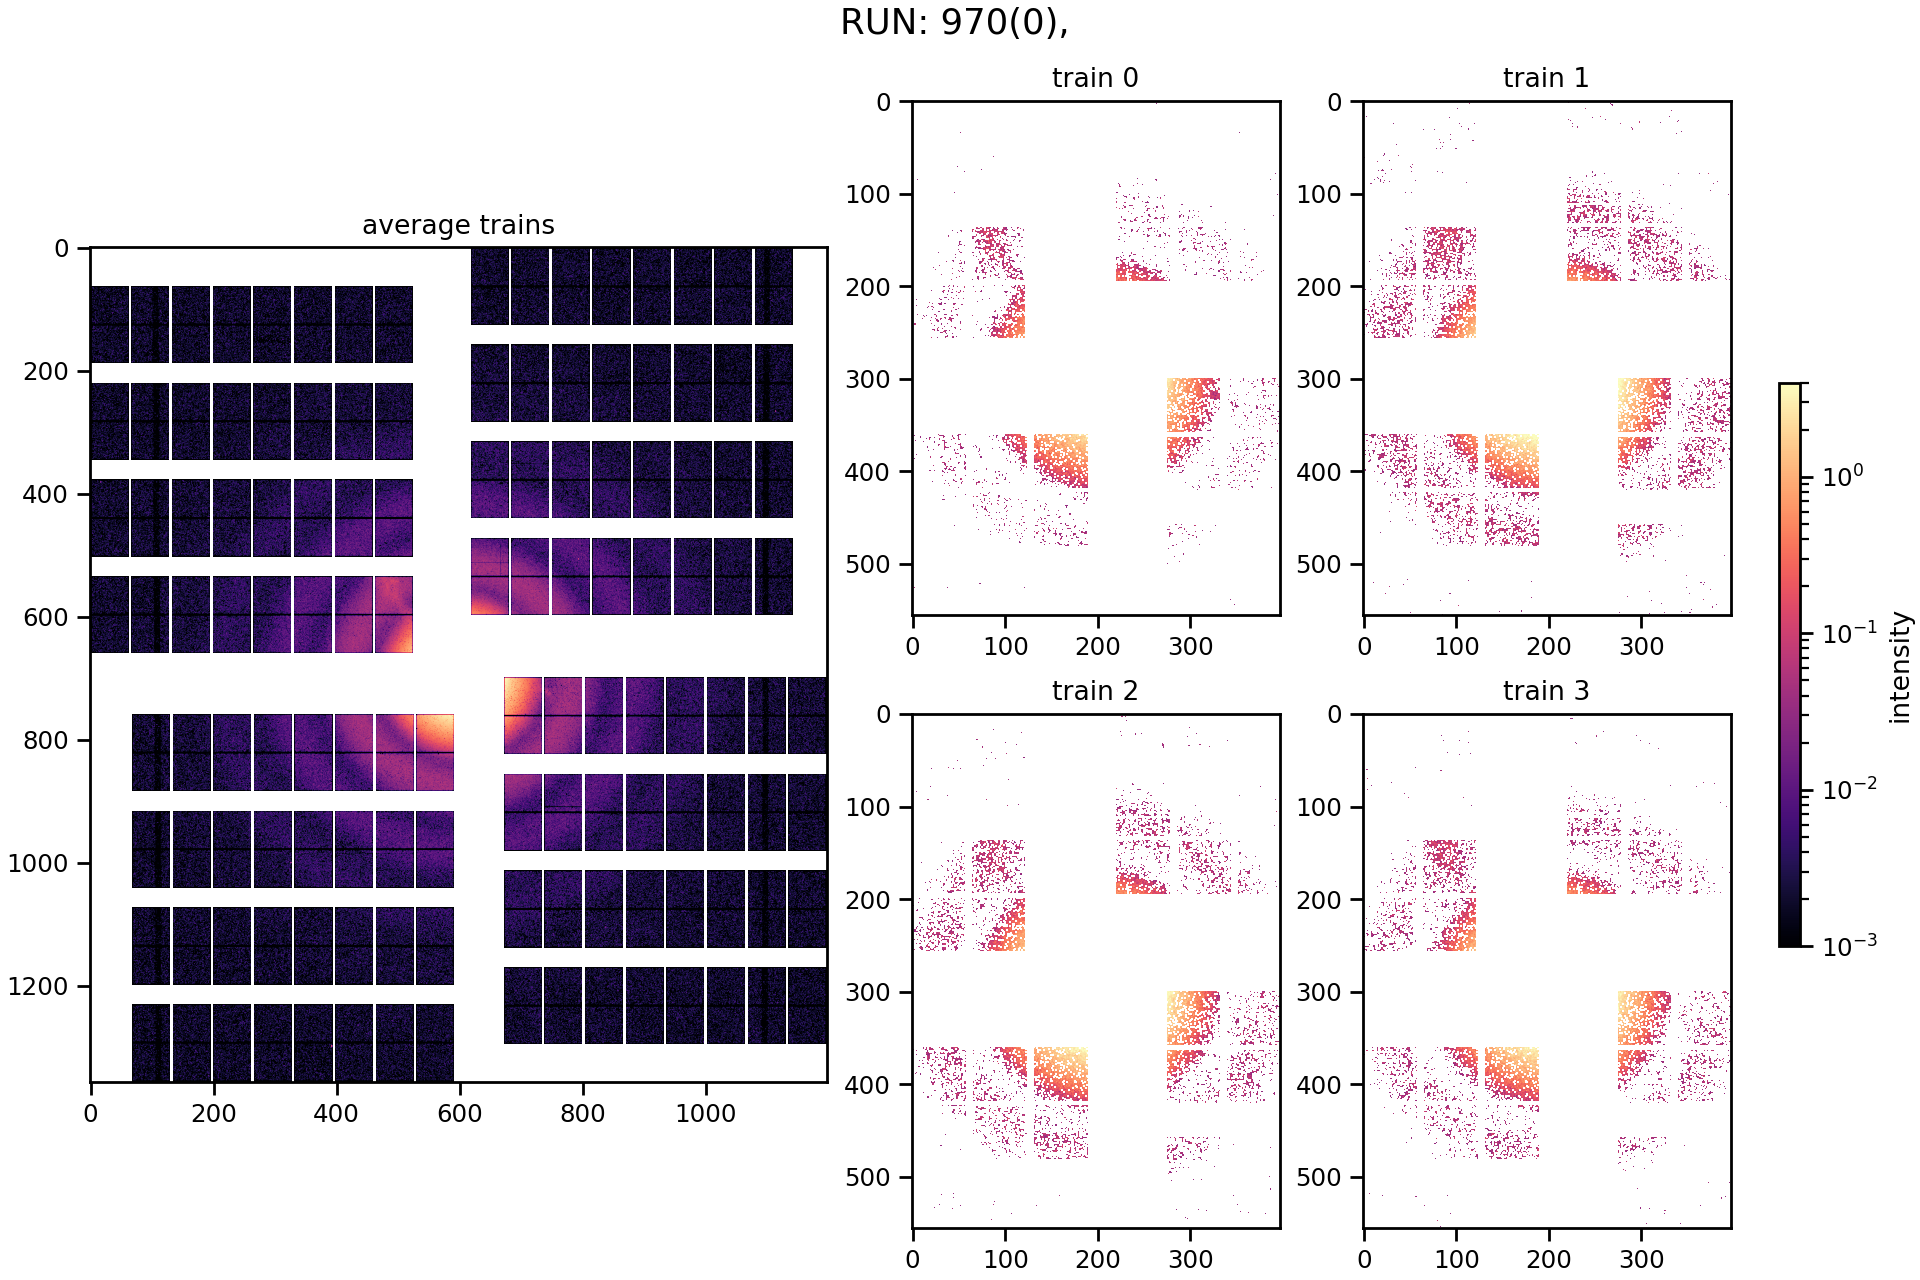

<IPython.core.display.Javascript object>


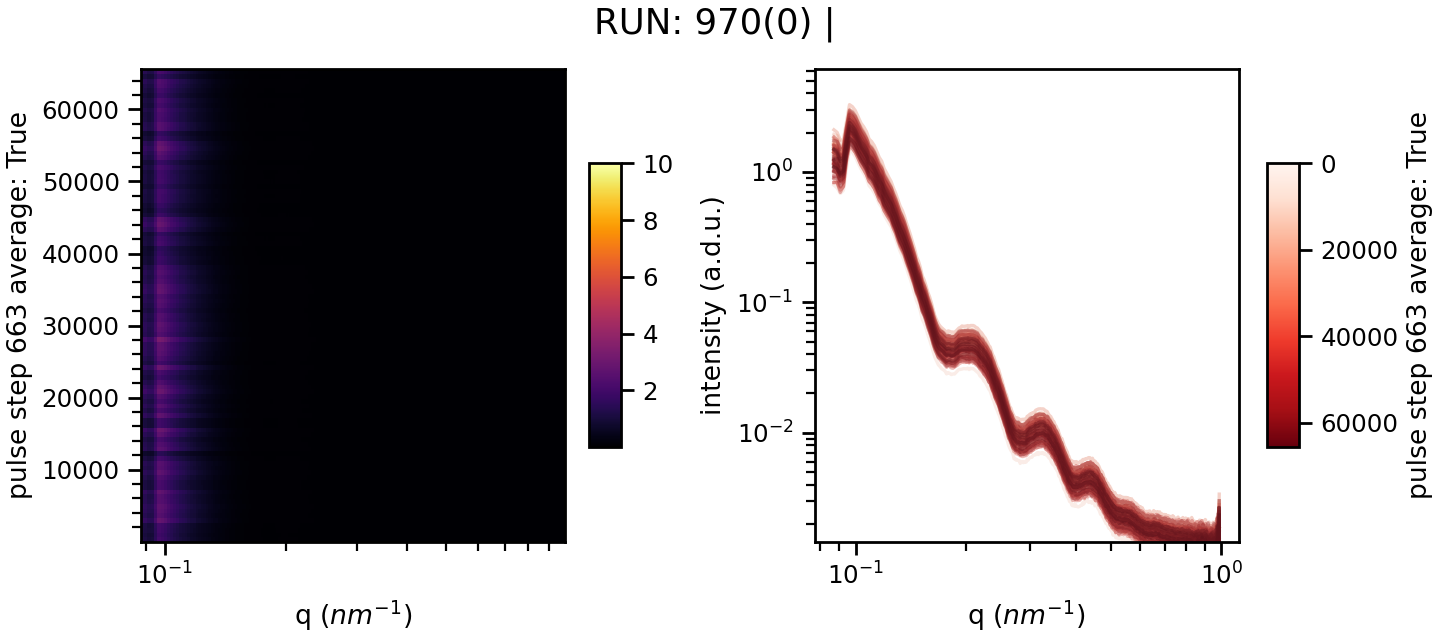

<IPython.core.display.Javascript object>


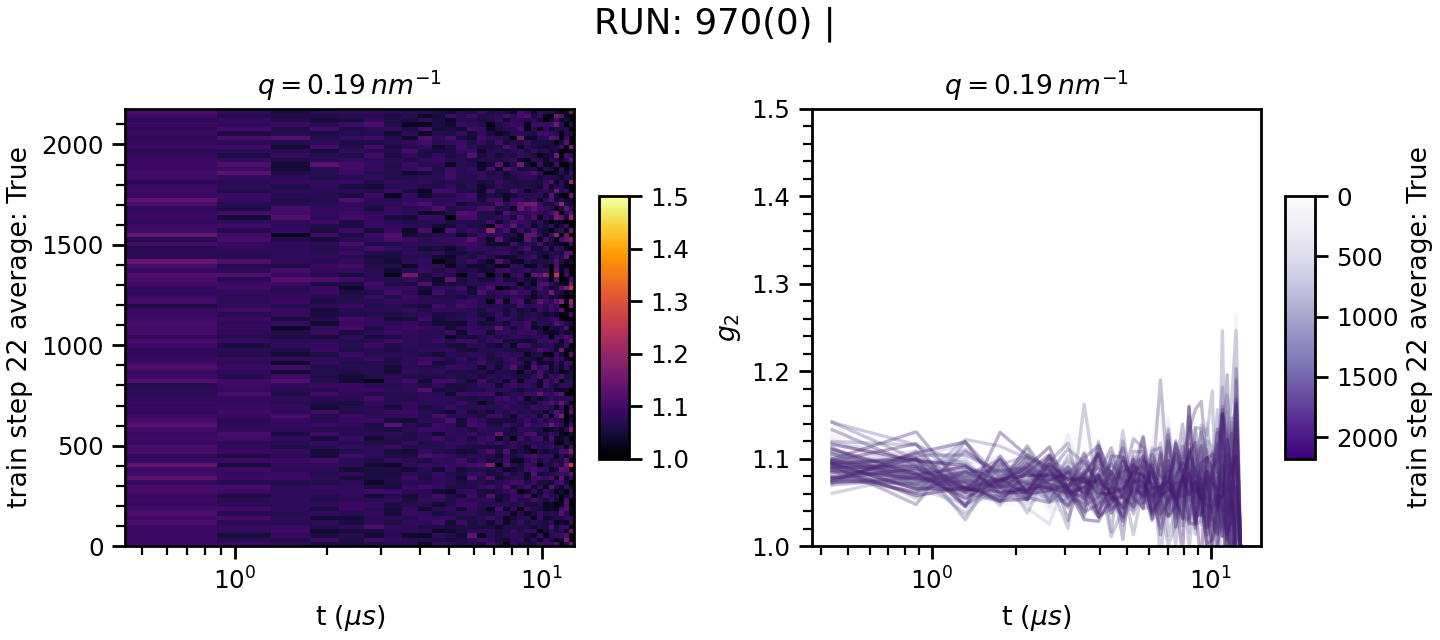

<IPython.core.display.Javascript object>


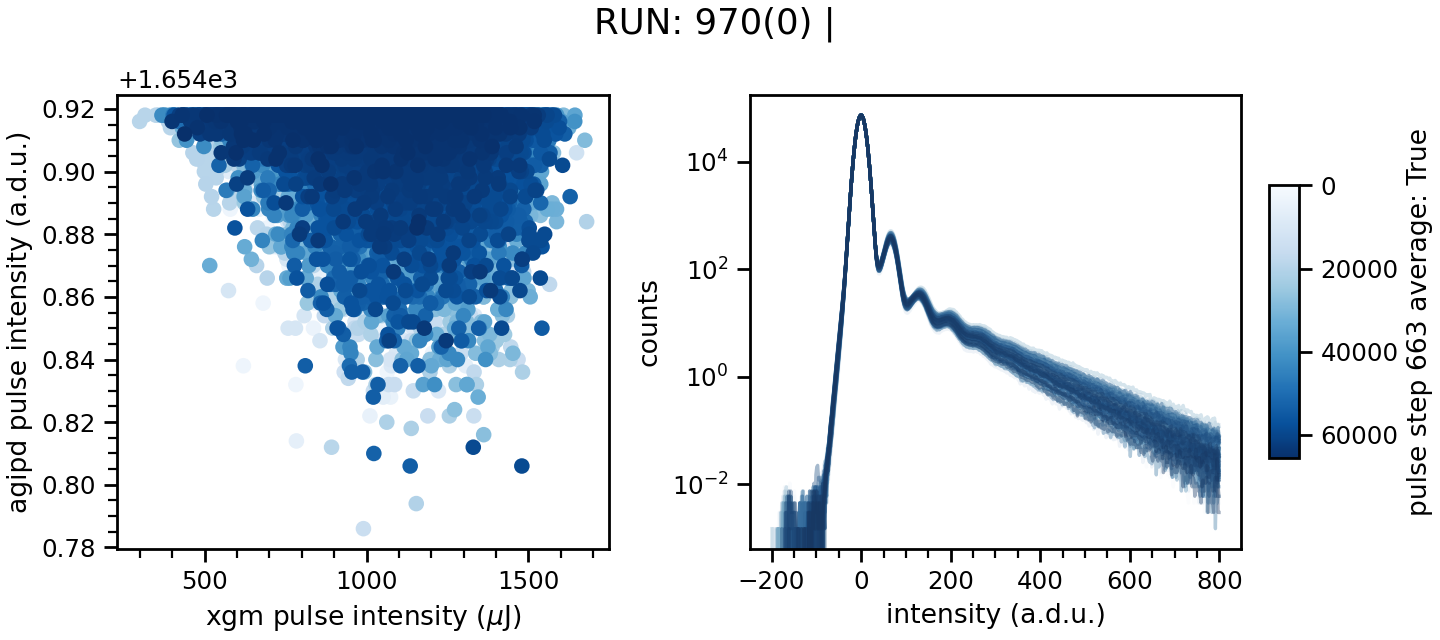

total 2211 trains
unique y steps (mm) [0.] occurred [2205]
unique z steps (mm) [0.    0.04  0.044] occurred [ 301 1085  745]
unique T steps (K) [0]
area: 0.10 x 26.00 (y * z)


<IPython.core.display.Javascript object>


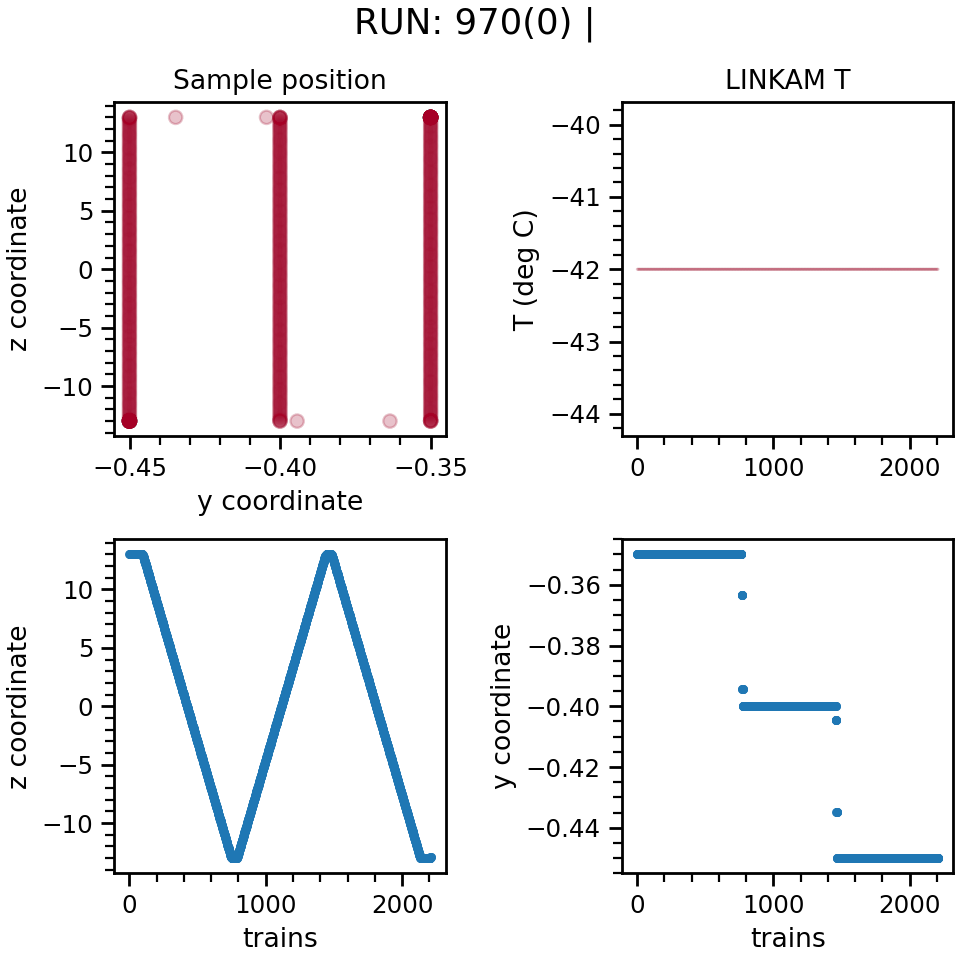

In [6]:
ds = Dataset(datasets, meta, geom, max_len=100, rebin_kws={'avr':True})
runid = 970
index = 0

ds.plot_xgm(runid, index)
ds.plot_images(runid, index, vmin=.001, vmax=4, log=True)
ds.plot_azimuthal_intensity(runid, index, vmax=10, vmin=None)
ds.plot_correlation_functions(runid, index, qval=.2, clim=(1,1.5), ylim=(1,1.5),)
ds.plot_statistics(runid, index)
ds.plot_sample_sources(runid, index)


<IPython.core.display.Javascript object>


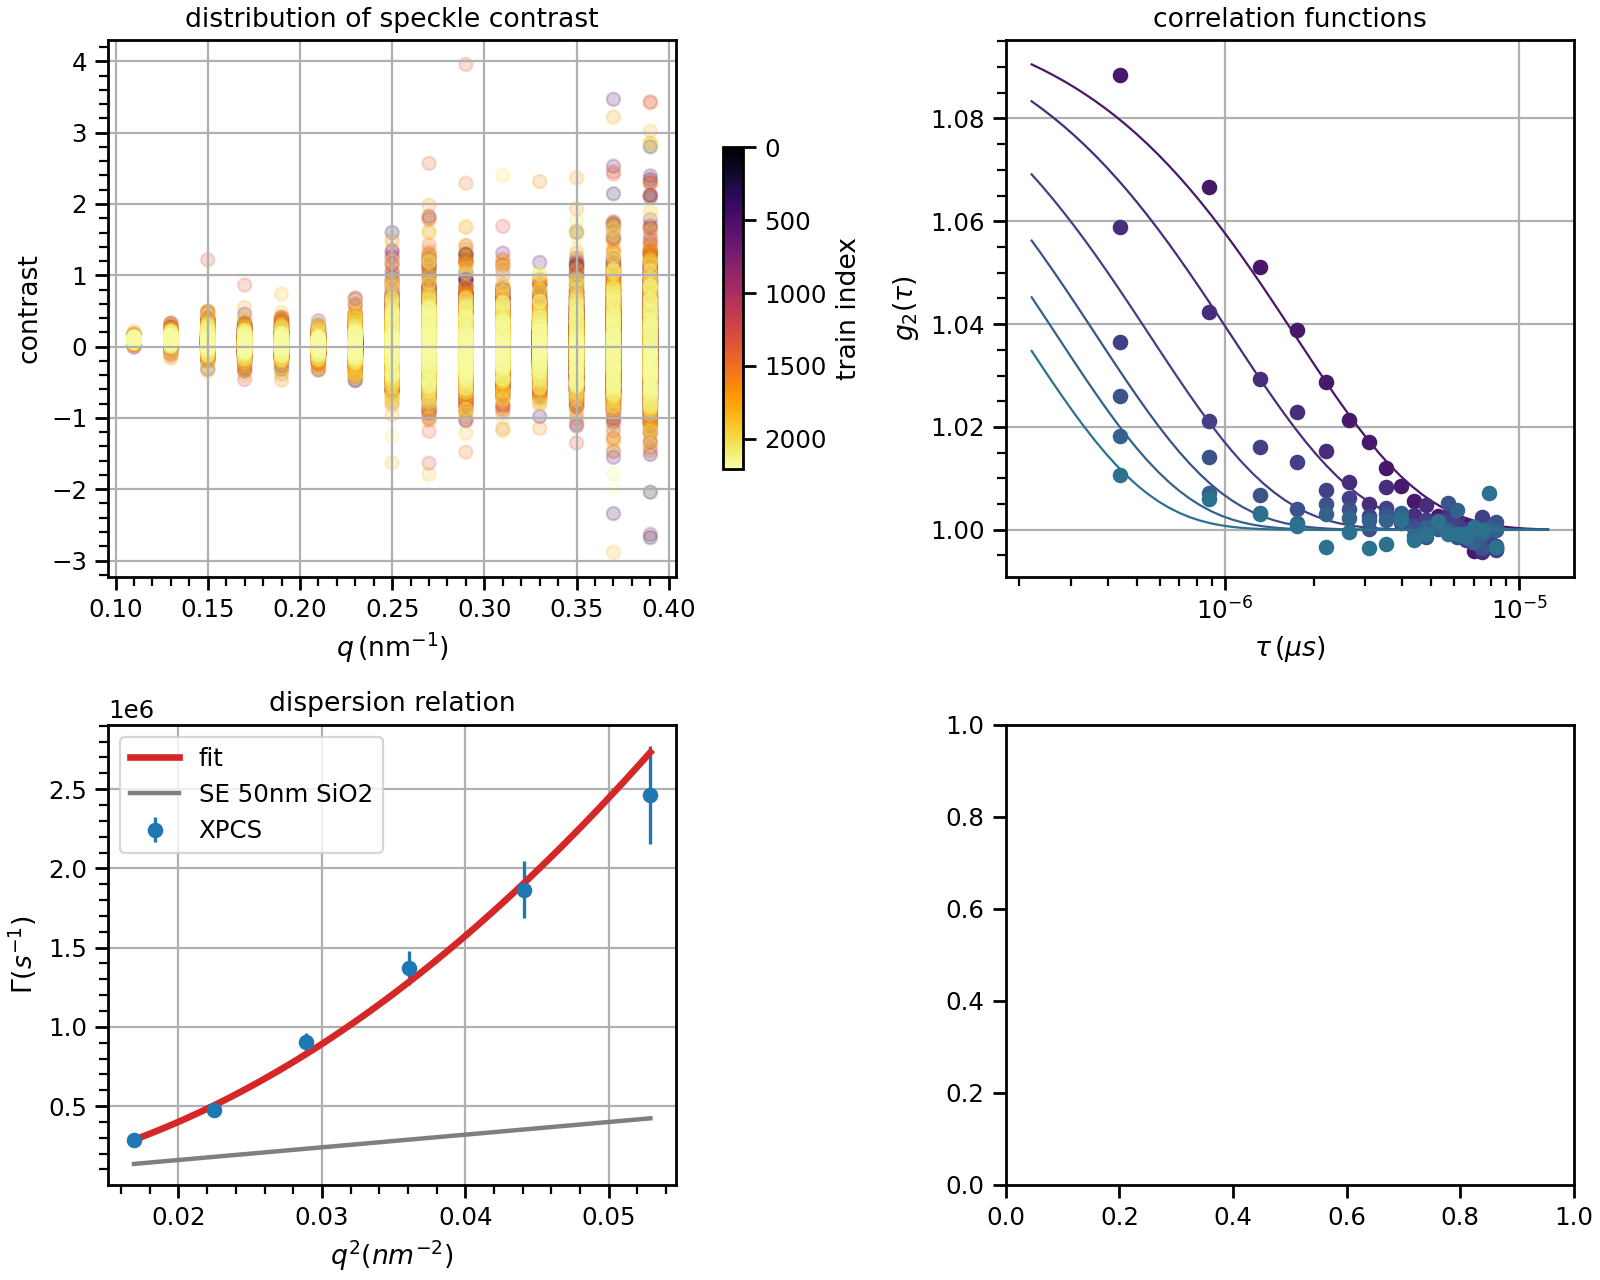

Optimizing...(0)Fit successful: True

Fit successful: True
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 621
    # data points      = 6
    # variables        = 2
    chi-square         = 4.21003258
    reduced chi-square = 1.05250814
    Akaike info crit   = 1.87426550
    Bayesian info crit = 1.45778444
[[Variables]]
    a:  9.0461e+08 +/- 2.5970e+08 (28.71%) (init = 7992472)
    n:  3.94806035 +/- 0.15468013 (3.92%) (init = 3)
    b:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, n) =  0.995


In [12]:
runid = 970
index = 0

# theoretical prediction
kb = 1.381e-23
T = 300
eta = 1e-3
R = 25e-9
D_si = kb*T / (6*np.pi*eta*R*1.1)*1e18 # stokes-einstein diffusion coef.
D_bsa = 19_000_000


ds = Dataset(datasets) # load data in xarray.Dataset
dset = ds.to_xDataset(runid, index)
dset = dset.assign({'contrast': dset['intercept'] - dset['baseline']}) # poor man's speckle contrast
dset = dset.isel(t_cor=slice(None,-10))

g2 = dset['g2'] - dset['g2'].isel(t_cor=slice(-10,None)).mean('t_cor') + 1 # shift g2 function to one
qv = dset.qv.copy()
    

fig, ax = subplots(2, 2, figsize=(10,8), constrained_layout=True, 
                   gridspec_kw={'height_ratios': [7,6]})

colors = sns.color_palette('inferno', dset.trainId.size)
cmaps = ['viridis', 'inferno']
avr_q_data = []
for qbin in range(qv.size):
    difi = dset['contrast'].isel(qv=qbin).values
    g2q = g2.isel(qv=qbin)
    avr_q_data.append([])
    ax.flat[0].scatter(np.repeat(qv[qbin].values, difi.size), difi, 
                       c=np.arange(difi.size), cmap='inferno', alpha=.2)
    avr_q_data[-1].append(g2q.mean('trainId'))

# this format is required by the G2 class to process correlation functions
avr_q_data = np.vstack(avr_q_data).T
gful = np.pad(avr_q_data, ((1,0),(1,0)), constant_values=0)
gful[1:,0] = dset.t_cor
gful[0, 1:] = qv    

# select the q-bins based on their index
qbinl = np.arange(1,7,1)

g2f = G2(gful, qbinl)
res = g2f.fit(mode='data_fit', nmodes=1,
              init={'a':(1.,.5,1.5),
                    't0':(1e-6, 0, 1e-4),
                    'beta':(.2, 0,1),
                    'g0': (1.2, 0,3)}, 
              fix={'a':1, 'g0':1},
              fitglobal=['g0', 'beta',],
             )
print(f'Fit successful: {res[1][0][0].errorbars}')
g2f.plot('data_fit', ax=ax.flat[1], 
         colors=sns.color_palette(cmaps[0], qv.size), 
         markeredgecolor=None)
    
ax.flat[0].set_xlabel('$q\,(\mathrm{nm}^{-1})$') 
ax.flat[0].set_ylabel('contrast') 
ax.flat[0].set_title('distribution of speckle contrast')
ax.flat[0].minorticks_on()
ax.flat[0].grid(1)
add_colorbar(ax.flat[0], np.arange(dset.trainId.size), shrink=.6, cmap='inferno', label='train index')

ax.flat[1].set_ylim(1, None)
ax.flat[1].grid(1)
ax.flat[1].autoscale()
ax.flat[1].set_xlabel(r"$\tau\,(\mu s)$")
ax.flat[1].set_title('correlation functions')
ax.flat[1].minorticks_on()

    
# plot dispersion relation
x = np.array(g2f.pars['q'])
y = np.array(1/g2f.pars['t0'])
dy = np.array(1/g2f.pars['t0']**2 * g2f.pars['dt0'])
ax.flat[2].errorbar(x**2, y, yerr=dy, fmt='o', label='XPCS')
ax.flat[2].minorticks_on()
pars_arr, gof, out, fit_report, model = fit_basic(
                                x, y, dy, 
                                model='power', 
                                method='differential_evolution',
                                init={'a': (D_si, D_si/1000, D_si*1000),
                                      'n': (3, 0, 10),
                                    },
                                fix={'b': 0,},)
print(f'\nFit successful: {out.errorbars}')
print(fit_report)
xf = np.linspace(x.min(), x.max(), 100)
yf = model.eval(params=out.params, x=xf)
ax.flat[2].plot(xf**2, yf, 'tab:red', lw=3, label='fit')


xf = np.linspace(x.min(), x.max(), 100)
yf = xf**2 * D_si
ax.flat[2].plot(xf**2, yf, 'tab:grey', lw=2, label='SE 50nm SiO2')
ax.flat[2].set_xlabel('$q^2 (nm^{-2})$')
ax.flat[2].set_ylabel('$\Gamma (s^{-1})$')
ax.flat[2].set_title('dispersion relation')
ax.flat[2].minorticks_on()
ax.flat[2].legend();
ax.flat[2].grid(1)